# End-to-End Variable Selection for Logistic Regression
## Ensemble Methods with Nested Cross-Validation

This notebook implements a comprehensive variable selection pipeline for fair lending logistic regression models, incorporating:

1. **Data Preparation & Profiling**
2. **Assumption Pre-Screening** (EPV, separation checks)
3. **Filter Methods** (IV, Mutual Information, Correlation)
4. **Multicollinearity Assessment** (VIF)
5. **Nested CV with Ensemble Selection** (LASSO, Elastic Net, RFE, Forward Selection, Tree Importance)
6. **Assumption Validation** (Linearity in logit, VIF on final set)
7. **Final Model Diagnostics**

---

## 1. Setup and Imports

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Import our custom utilities
from variable_selection_utils import (
    # Data generation
    generate_fair_lending_data,
    
    # Assumption validation
    calculate_epv,
    calculate_vif,
    iterative_vif_elimination,
    check_separation,
    box_tidwell_test,
    
    # Filter methods
    calculate_all_iv,
    calculate_mutual_information,
    correlation_filter,
    
    # Selection methods
    lasso_selection,
    elastic_net_selection,
    rfe_selection,
    forward_selection,
    mutual_info_selection,
    tree_importance_selection,
    iv_selection,
    
    # Nested CV
    NestedCVVariableSelector,
    
    # Diagnostics and visualization
    final_model_diagnostics,
    plot_feature_importance_comparison,
    plot_stability_across_folds,
    plot_cv_performance
)

print("All imports successful!")

All imports successful!


---
## 2. Generate Fair Lending Dataset

We generate a synthetic dataset with realistic fair lending attributes including:
- Credit characteristics (score, utilization, delinquencies)
- Loan characteristics (amount, LTV, interest rate)
- Employment information
- Noise features (to test selection robustness)
- Correlated features (to test multicollinearity handling)

In [22]:
# Generate dataset
RANDOM_STATE = 42
N_SAMPLES = 10000
exclude_cols = ['application_date']  # Exclude date column from certain checks

_X, y = generate_fair_lending_data(
    n_samples=N_SAMPLES,
    random_state=RANDOM_STATE,
    default_rate=0.15,
    n_noise_features=10
)

print(f"\nDataset shape: {_X.shape}")
print(f"Target distribution:")
print(pd.Series(y).value_counts(normalize=True))

X = _X.drop(columns=exclude_cols)  # Drop date column for now

Generated dataset: 10000 samples, 34 features
Default rate: 4.34%
Date distribution:
application_date
2021    2000
2022    2000
2023    2000
2024    2000
2025    2000
Name: count, dtype: int64

Dataset shape: (10000, 34)
Target distribution:
0   0.9566
1   0.0434
Name: proportion, dtype: float64


In [23]:
# Quick data overview
desc = X.describe(include='all').T

# Add unique levels for each variable
desc['n_unique'] = X.nunique()

# Add data type for each variable
desc['dtype'] = X.dtypes.astype(str)

desc

,count,mean,std,min,25%,50%,75%,max,n_unique,dtype
credit_score,10000.0000,679.3249,79.0256,366.2080,626.1928,679.7924,733.6865,850.0000,9836,float64
dti_ratio,10000.0000,24.9601,13.7159,10.0007,14.4668,20.7392,31.2328,65.0000,9723,float64
ltv_ratio,10000.0000,77.8467,11.4773,50.0000,69.7146,77.9721,86.0812,100.0000,9587,float64
annual_income,10000.0000,67307.4990,36010.3511,20000.0000,42029.0534,59371.0726,83687.0347,386125.0935,9860,float64
loan_amount,10000.0000,235436.0985,139924.4487,50000.0000,136205.1632,202939.3277,296753.0657,1000000.0000,9934,float64
employment_length,10000.0000,4.9611,4.9085,0.0002,1.4595,3.4608,6.9744,40.0000,9999,float64
employment_type,10000.0000,1.9738,0.5221,0.0000,2.0000,2.0000,2.0000,3.0000,4,int64
num_delinquencies,10000.0000,0.5026,0.7095,0.0000,0.0000,0.0000,1.0000,5.0000,6,int32
months_since_delinq,10000.0000,9.2081,18.3160,0.0000,0.0000,0.0000,10.7119,120.0000,3938,float64
num_inquiries,10000.0000,1.4902,1.2233,0.0000,1.0000,1.0000,2.0000,8.0000,9,int32


In [24]:
# Check for missing values
missing = X.isnull().sum()
print(f"Missing values: {missing.sum()}")

# Check for infinite values
inf_counts = np.isinf(X.select_dtypes(include=[np.number])).sum()
print(f"Infinite values: {inf_counts.sum()}")

#show only columns with missing values
X.isnull().sum()[X.isnull().sum() > 0]

Missing values: 0
Infinite values: 0


Series([], dtype: int64)

---
## 3. Phase 1: Assumption Pre-Screening

Before running selection methods, we validate key logistic regression assumptions.

### 3.1 Events Per Variable (EPV) Check

In [25]:
# Calculate EPV with all candidate variables
epv_results = calculate_epv(y, n_vars=X.shape[1])

print("=" * 50)
print("EVENTS PER VARIABLE (EPV) ANALYSIS")
print("=" * 50)
print(f"Number of events (defaults): {epv_results['n_events']}")
print(f"Number of non-events: {epv_results['n_non_events']}")
print(f"Number of candidate variables: {epv_results['n_variables']}")
print(f"\nEPV Ratio: {epv_results['epv_ratio']:.2f}")
print(f"Meets minimum EPV ≥ 10: {'✓ YES' if epv_results['meets_minimum_10'] else '✗ NO'}")
print(f"Meets robust EPV ≥ 20: {'✓ YES' if epv_results['meets_robust_20'] else '✗ NO'}")
print(f"\nMax recommended variables (EPV=10): {epv_results['max_recommended_vars']}")

EVENTS PER VARIABLE (EPV) ANALYSIS
Number of events (defaults): 434
Number of non-events: 9566
Number of candidate variables: 33

EPV Ratio: 13.15
Meets minimum EPV ≥ 10: ✓ YES
Meets robust EPV ≥ 20: ✗ NO

Max recommended variables (EPV=10): 43


### 3.2 Check for Perfect/Quasi Separation

In [26]:
# Check for separation issues
separation_issues = check_separation(X, y)

print("=" * 50)
print("SEPARATION CHECK")
print("=" * 50)
print(f"Features with perfect separation: {len(separation_issues['perfect_separation'])}")
if separation_issues['perfect_separation']:
    print(f"  → {separation_issues['perfect_separation']}")
print(f"\nFeatures with quasi-separation: {len(separation_issues['quasi_separation'])}")
if separation_issues['quasi_separation']:
    print(f"  → {separation_issues['quasi_separation']}")
    

SEPARATION CHECK
Features with perfect separation: 0

Features with quasi-separation: 0


---
## 4. Phase 2: Filter Methods

Apply univariate screening methods to get initial feature rankings.

### 4.1 Information Value (IV) Analysis

In [27]:
# Calculate IV for all features
iv_df = calculate_all_iv(X, y, bins=10)

print("=" * 50)
print("INFORMATION VALUE RANKINGS")
print("=" * 50)
print(iv_df.head(20).to_string(index=False))

INFORMATION VALUE RANKINGS
           feature     iv            predictive_strength
      credit_score 1.1407 Suspicious (check for leakage)
        fico_score 1.1185 Suspicious (check for leakage)
         dti_ratio 1.0276 Suspicious (check for leakage)
     interest_rate 0.8549 Suspicious (check for leakage)
         ltv_ratio 0.2041                         Medium
credit_utilization 0.1494                         Medium
         pti_ratio 0.0997                           Weak
    property_value 0.0862                           Weak
     annual_income 0.0779                           Weak
    monthly_income 0.0779                           Weak
total_credit_limit 0.0704                           Weak
 num_delinquencies 0.0684                           Weak
     num_inquiries 0.0548                           Weak
          noise_10 0.0454                           Weak
       loan_amount 0.0395                           Weak
 employment_length 0.0319                           Weak
    

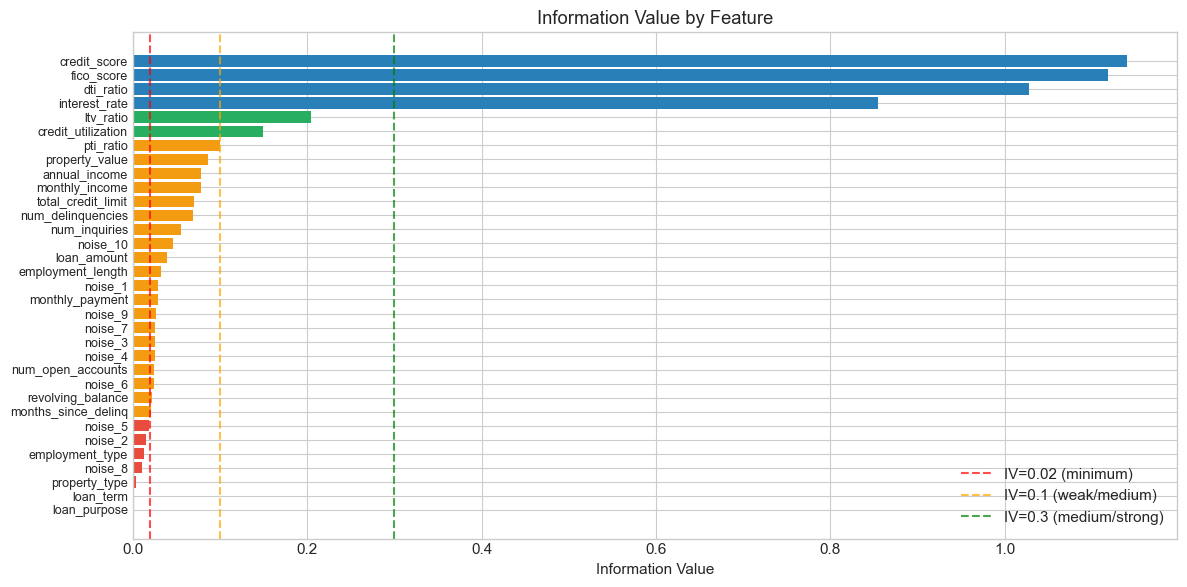


Summary:
  Not predictive (IV < 0.02): 7 features
  Weak (0.02 ≤ IV < 0.1): 20 features
  Medium (0.1 ≤ IV < 0.3): 2 features
  Strong (IV ≥ 0.3): 4 features


In [28]:
# Visualize IV distribution
fig, ax = plt.subplots(figsize=(12, 6))

# Color by predictive strength
colors = []
for iv in iv_df['iv']:
    if iv < 0.02:
        colors.append('#e74c3c')  # Red - not predictive
    elif iv < 0.1:
        colors.append('#f39c12')  # Orange - weak
    elif iv < 0.3:
        colors.append('#27ae60')  # Green - medium
    else:
        colors.append('#2980b9')  # Blue - strong

bars = ax.barh(range(len(iv_df)), iv_df['iv'], color=colors)
ax.set_yticks(range(len(iv_df)))
ax.set_yticklabels(iv_df['feature'], fontsize=9)
ax.set_xlabel('Information Value')
ax.set_title('Information Value by Feature')
ax.axvline(x=0.02, color='red', linestyle='--', alpha=0.7, label='IV=0.02 (minimum)')
ax.axvline(x=0.1, color='orange', linestyle='--', alpha=0.7, label='IV=0.1 (weak/medium)')
ax.axvline(x=0.3, color='green', linestyle='--', alpha=0.7, label='IV=0.3 (medium/strong)')
ax.legend(loc='lower right')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# Summary
print(f"\nSummary:")
print(f"  Not predictive (IV < 0.02): {(iv_df['iv'] < 0.02).sum()} features")
print(f"  Weak (0.02 ≤ IV < 0.1): {((iv_df['iv'] >= 0.02) & (iv_df['iv'] < 0.1)).sum()} features")
print(f"  Medium (0.1 ≤ IV < 0.3): {((iv_df['iv'] >= 0.1) & (iv_df['iv'] < 0.3)).sum()} features")
print(f"  Strong (IV ≥ 0.3): {(iv_df['iv'] >= 0.3).sum()} features")

### 4.2 Mutual Information Analysis

- MI = 0: feature and target are independent (no relationship)
- MI > 0: feature proves some information about target (higher values = stronger relationship)

Note: MI does not have fixed upper bound, scores should be compared relative to each other 

In [29]:
# Calculate Mutual Information
mi_df = calculate_mutual_information(X, y, random_state=RANDOM_STATE)

print("=" * 50)
print("MUTUAL INFORMATION RANKINGS")
print("=" * 50)
print(mi_df.head(15).to_string(index=False))

MUTUAL INFORMATION RANKINGS
          feature  mutual_information
       fico_score              0.0250
        dti_ratio              0.0248
     credit_score              0.0225
    interest_rate              0.0176
         noise_10              0.0040
num_open_accounts              0.0033
          noise_4              0.0032
          noise_3              0.0030
num_delinquencies              0.0026
   property_value              0.0023
        loan_term              0.0022
  employment_type              0.0021
    num_inquiries              0.0016
    property_type              0.0015
        pti_ratio              0.0015


### 4.3 Correlation Analysis & Multicollinearity

In [30]:
# Identify highly correlated pairs
corr_matrix, high_corr_pairs = correlation_filter(X, y, threshold=0.7)

print("=" * 50)
print("HIGH CORRELATION PAIRS (|r| > 0.7)")
print("=" * 50)
if high_corr_pairs:
    for f1, f2, corr in sorted(high_corr_pairs, key=lambda x: -x[2]):
        print(f"  {f1} ↔ {f2}: r = {corr:.3f}")
else:
    print("  No highly correlated pairs found.")

HIGH CORRELATION PAIRS (|r| > 0.7)
  annual_income ↔ monthly_income: r = 1.000
  credit_score ↔ fico_score: r = 0.998
  loan_amount ↔ property_value: r = 0.956
  loan_amount ↔ monthly_payment: r = 0.943
  property_value ↔ monthly_payment: r = 0.902
  loan_amount ↔ monthly_income: r = 0.884
  annual_income ↔ loan_amount: r = 0.884
  credit_score ↔ interest_rate: r = 0.847
  interest_rate ↔ fico_score: r = 0.845
  property_value ↔ monthly_income: r = 0.845
  annual_income ↔ property_value: r = 0.845
  monthly_payment ↔ monthly_income: r = 0.836
  annual_income ↔ monthly_payment: r = 0.836
  total_credit_limit ↔ monthly_income: r = 0.773
  annual_income ↔ total_credit_limit: r = 0.773
  total_credit_limit ↔ revolving_balance: r = 0.709


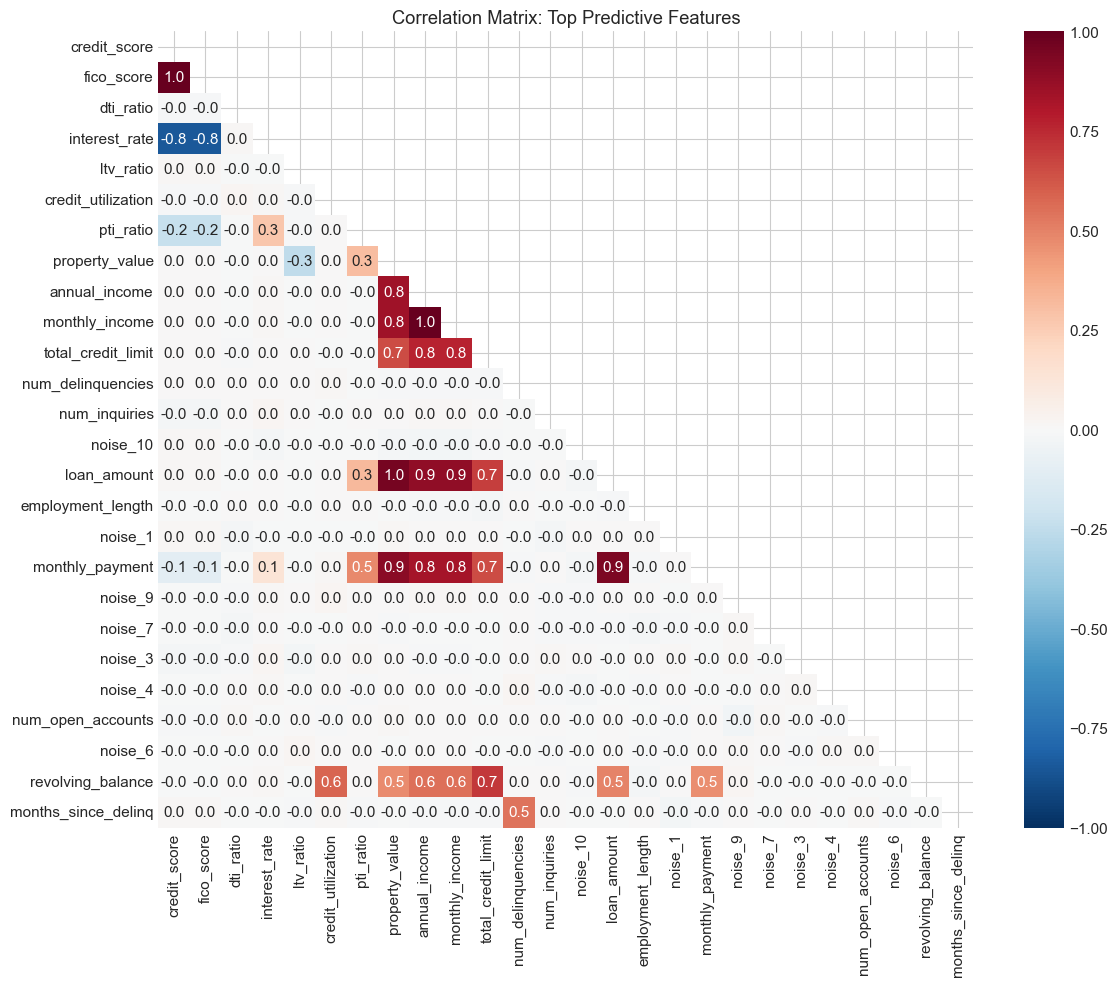

In [35]:
# Correlation heatmap for top predictive features
top_features = iv_df[iv_df['iv'] >= 0.02]['feature'].tolist()

if len(top_features) > 1:
    fig, ax = plt.subplots(figsize=(12, 10))
    corr_subset = X[top_features].corr()
    mask = np.triu(np.ones_like(corr_subset, dtype=bool))
    sns.heatmap(corr_subset, mask=mask, annot=True, fmt='.1f', 
                cmap='RdBu_r', center=0, ax=ax, vmin=-1, vmax=1)
    ax.set_title('Correlation Matrix: Top Predictive Features')
    plt.tight_layout()
    plt.show()

### 4.4 Variance Inflation Factor (VIF) Analysis

In [37]:
# Calculate VIF for all features
vif_df = calculate_vif(X)

print("=" * 50)
print("VARIANCE INFLATION FACTOR (VIF)")
print("=" * 50)
print(f"Features with VIF > 10: {(vif_df['vif'] > 10).sum()}")
print(f"Features with VIF > 5: {(vif_df['vif'] > 5).sum()}")
print(f"\nTop 10 by VIF:")
print(vif_df.head(10).to_string(index=False))
vif_df

VARIANCE INFLATION FACTOR (VIF)
Features with VIF > 10: 16
Features with VIF > 5: 16

Top 10 by VIF:
        feature        vif
  annual_income        inf
 monthly_income        inf
   credit_score 18463.5428
     fico_score 18423.5925
    loan_amount   251.7906
      ltv_ratio   135.2514
 property_value   125.5109
monthly_payment   115.9192
  interest_rate    78.9492
      loan_term    66.6087


,feature,vif
3,annual_income,inf
21,monthly_income,inf
0,credit_score,18463.5428
22,fico_score,18423.5925
4,loan_amount,251.7906
2,ltv_ratio,135.2514
17,property_value,125.5109
20,monthly_payment,115.9192
14,interest_rate,78.9492
15,loan_term,66.6087


In [40]:
# Iteratively remove high-VIF features
print("\n" + "=" * 50)
print("ITERATIVE VIF ELIMINATION (threshold=5.0)")
print("=" * 50)

retained_features, removal_history = iterative_vif_elimination(X, threshold=10.0, verbose=True)

print(f"\nRetained {len(retained_features)} features after VIF elimination")
print(f"Removed {len(removal_history)} features")


ITERATIVE VIF ELIMINATION (threshold=5.0)
  Removing annual_income (VIF=inf)
  Removing credit_score (VIF=18463.54)
  Removing loan_amount (VIF=251.59)
  Removing ltv_ratio (VIF=100.37)
  Removing monthly_payment (VIF=64.37)
  Removing fico_score (VIF=50.12)
  Removing interest_rate (VIF=32.97)
  Removing monthly_income (VIF=25.52)
  Removing total_credit_limit (VIF=14.02)
  Removing loan_term (VIF=13.42)
  Removing pti_ratio (VIF=11.48)
  Removing employment_type (VIF=10.14)

Retained 21 features after VIF elimination
Removed 12 features


In [41]:
# Create VIF-filtered feature set for further analysis
X_vif_filtered = X[retained_features].copy()
print(f"VIF-filtered dataset shape: {X_vif_filtered.shape}")

VIF-filtered dataset shape: (10000, 21)


---
## 5. Phase 3-4: Nested CV with Ensemble Variable Selection

This is the core of our variable selection process. We use nested cross-validation to:
1. Avoid information leakage in performance estimation
2. Run multiple selection methods in the inner loop
3. Aggregate selections via majority voting
4. Evaluate on truly held-out outer test folds

In [42]:
# Define selection methods for the ensemble
selection_methods = {
    'LASSO': lasso_selection,
    'Elastic_Net': elastic_net_selection,
    'RFE': rfe_selection,
    'Forward': forward_selection,
    'MI': mutual_info_selection,
    'Tree_Importance': tree_importance_selection,
    'IV': iv_selection
}

print(f"Running {len(selection_methods)} selection methods:")
for name in selection_methods:
    print(f"  • {name}")

Running 7 selection methods:
  • LASSO
  • Elastic_Net
  • RFE
  • Forward
  • MI
  • Tree_Importance
  • IV


In [43]:
# Initialize and run Nested CV
nested_cv = NestedCVVariableSelector(
    outer_cv=5,
    inner_cv=5,
    random_state=RANDOM_STATE,
    min_votes=4,  # Feature must be selected by at least 4 of 7 methods
    verbose=True
)

# Run the nested CV process (this takes a few minutes)
print("\nStarting Nested CV Variable Selection...")
print("(This may take 2-5 minutes depending on your hardware)\n")

nested_cv.fit(X_vif_filtered, y, selection_methods)


Starting Nested CV Variable Selection...
(This may take 2-5 minutes depending on your hardware)


OUTER FOLD 1/5

  Running LASSO...
    Selected 13 features

  Running Elastic_Net...
    Selected 8 features

  Running RFE...
    Selected 6 features

  Running Forward...
    Selected 4 features

  Running MI...
    Selected 15 features

  Running Tree_Importance...
    Selected 15 features

  Running IV...
    Selected 14 features

  Consensus features (9): ['dti_ratio', 'employment_length', 'num_delinquencies', 'num_inquiries', 'credit_utilization']...

  OUTER FOLD 1 RESULTS:
    ROC-AUC: 0.8131
    Brier Score: 0.0361

OUTER FOLD 2/5

  Running LASSO...
    Selected 20 features

  Running Elastic_Net...
    Selected 12 features

  Running RFE...
    Selected 13 features

  Running Forward...
    Selected 5 features

  Running MI...
    Selected 15 features

  Running Tree_Importance...
    Selected 15 features

  Running IV...
    Selected 17 features

  Consensus features (15): ['

In [ ]:
# Get results summary
results_df, summary = nested_cv.get_results_summary()

print("\n" + "=" * 60)
print("NESTED CV RESULTS SUMMARY")
print("=" * 60)
print(f"\nPerformance (Outer Folds):")
print(f"  ROC-AUC: {summary['mean_roc_auc']:.4f} ± {summary['std_roc_auc']:.4f}")
print(f"  Brier Score: {summary['mean_brier']:.4f} ± {summary['std_brier']:.4f}")
print(f"  Log Loss: {summary['mean_log_loss']:.4f} ± {summary['std_log_loss']:.4f}")
print(f"\nVariable Selection:")
print(f"  Mean features selected: {summary['mean_n_features']:.1f}")
print(f"  Selection stability (Kuncheva): {summary['kuncheva_stability']:.3f}")
print(f"\nStability Assessment:")
print(f"  Features in ≥80% of folds: {nested_cv.feature_selection_stability_['n_stable_features_80']}")
print(f"  Features in ≥60% of folds: {nested_cv.feature_selection_stability_['n_stable_features_60']}")

In [ ]:
# Detailed fold-by-fold results
print("\nFold-by-Fold Results:")
print(results_df[['fold', 'n_features', 'roc_auc', 'brier_score']].to_string(index=False))

In [ ]:
# Visualize CV performance
fig, axes = plot_cv_performance(nested_cv, figsize=(12, 5))
plt.show()

In [ ]:
# Feature selection stability
feature_votes = nested_cv.get_feature_votes()

print("\n" + "=" * 60)
print("FEATURE SELECTION STABILITY")
print("=" * 60)
print(feature_votes.head(20).to_string(index=False))

In [ ]:
# Visualize stability
fig, ax = plot_stability_across_folds(nested_cv, top_n=20, figsize=(10, 8))
plt.show()

---
## 6. Phase 5: Final Variable Set Selection

Based on stability analysis, we select features that were consistently chosen across CV folds.

In [ ]:
# Get stable features (selected in ≥80% of folds)
stable_features_80 = nested_cv.get_stable_features(threshold=0.8)
stable_features_60 = nested_cv.get_stable_features(threshold=0.6)

print("=" * 60)
print("STABLE FEATURE SETS")
print("=" * 60)
print(f"\n80% Stability Threshold ({len(stable_features_80)} features):")
for f in stable_features_80:
    freq = nested_cv.feature_selection_stability_['feature_frequencies'][f]
    print(f"  • {f} ({freq:.0%})")

print(f"\n60% Stability Threshold ({len(stable_features_60)} features):")
for f in stable_features_60:
    freq = nested_cv.feature_selection_stability_['feature_frequencies'][f]
    print(f"  • {f} ({freq:.0%})")

In [ ]:
# Select final feature set
# Use 60% threshold if 80% gives too few features
if len(stable_features_80) >= 5:
    final_features = stable_features_80
    stability_threshold = 0.8
else:
    final_features = stable_features_60
    stability_threshold = 0.6

print(f"\nFinal feature set ({len(final_features)} features, {stability_threshold:.0%} threshold):")
print(final_features)

---
## 7. Phase 6: Assumption Validation on Final Feature Set

Validate that the final variable set satisfies logistic regression assumptions.

### 7.1 VIF Check on Final Features

In [ ]:
# VIF on final feature set
X_final = X[final_features]
vif_final = calculate_vif(X_final)

print("=" * 60)
print("VIF CHECK ON FINAL FEATURES")
print("=" * 60)
print(vif_final.to_string(index=False))
print(f"\nMax VIF: {vif_final['vif'].max():.2f}")
print(f"All VIF < 5: {'✓ PASS' if (vif_final['vif'] < 5).all() else '✗ FAIL'}")

### 7.2 Linearity in Logit (Box-Tidwell Test)

In [ ]:
# Identify continuous variables in final set
continuous_vars = [col for col in final_features 
                   if X_final[col].nunique() > 10 and X_final[col].min() > 0]

if continuous_vars:
    print("=" * 60)
    print("BOX-TIDWELL TEST FOR LINEARITY IN LOGIT")
    print("=" * 60)
    
    bt_results = box_tidwell_test(X_final, y, continuous_vars)
    print(bt_results.to_string(index=False))
    
    n_nonlinear = (bt_results['linearity_holds'] == False).sum()
    print(f"\nVariables with potential non-linearity: {n_nonlinear}")
    if n_nonlinear > 0:
        print("Consider transformations (log, sqrt, binning) for these variables.")
else:
    print("No continuous positive variables for Box-Tidwell test.")

### 7.3 EPV Check on Final Features

In [ ]:
# EPV on final feature set
epv_final = calculate_epv(y, len(final_features))

print("=" * 60)
print("EPV CHECK ON FINAL FEATURES")
print("=" * 60)
print(f"Number of features: {len(final_features)}")
print(f"EPV Ratio: {epv_final['epv_ratio']:.2f}")
print(f"Meets EPV ≥ 10: {'✓ PASS' if epv_final['meets_minimum_10'] else '✗ FAIL'}")
print(f"Meets EPV ≥ 20: {'✓ PASS' if epv_final['meets_robust_20'] else '✗ CAUTION'}")

---
## 8. Phase 7: Final Model Diagnostics

Fit the final model and run comprehensive diagnostics.

In [ ]:
# Run comprehensive diagnostics
diagnostics = final_model_diagnostics(
    X, y, 
    feature_names=final_features,
    test_size=0.2,
    random_state=RANDOM_STATE
)

print("=" * 60)
print("FINAL MODEL DIAGNOSTICS")
print("=" * 60)
print(f"\nModel Convergence: {'✓ YES' if diagnostics['model_converged'] else '✗ NO'}")
print(f"Number of Features: {diagnostics['n_features']}")
print(f"EPV Ratio: {diagnostics['epv_ratio']:.2f}")

print(f"\nPerformance Metrics:")
print(f"  Train ROC-AUC: {diagnostics['train_roc_auc']:.4f}")
print(f"  Test ROC-AUC: {diagnostics['test_roc_auc']:.4f}")
print(f"  AUC Gap (overfitting check): {diagnostics['auc_gap']:.4f}")
print(f"  Train Brier Score: {diagnostics['train_brier']:.4f}")
print(f"  Test Brier Score: {diagnostics['test_brier']:.4f}")

print(f"\nModel Statistics:")
print(f"  Pseudo R²: {diagnostics['pseudo_r2']:.4f}")
print(f"  AIC: {diagnostics['aic']:.2f}")
print(f"  BIC: {diagnostics['bic']:.2f}")

print(f"\nMulticollinearity Check:")
print(f"  Max VIF: {diagnostics['max_vif']:.2f}")
print(f"  All VIF < 5: {'✓ PASS' if diagnostics['all_vif_below_5'] else '✗ FAIL'}")

In [ ]:
# Coefficient summary
print("\n" + "=" * 60)
print("COEFFICIENT SUMMARY")
print("=" * 60)
coef_df = diagnostics['coefficients']
print(coef_df.to_string(index=False))

In [ ]:
# Visualize coefficients
fig, ax = plt.subplots(figsize=(10, 6))

# Exclude constant
coef_plot = coef_df[coef_df['feature'] != 'const'].copy()
coef_plot = coef_plot.sort_values('coef')

colors = ['#e74c3c' if p < 0.05 else '#95a5a6' for p in coef_plot['p_value']]
ax.barh(range(len(coef_plot)), coef_plot['coef'], color=colors)
ax.set_yticks(range(len(coef_plot)))
ax.set_yticklabels(coef_plot['feature'])
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('Coefficient (Standardized)')
ax.set_title('Logistic Regression Coefficients\n(Red = significant at p<0.05)')
plt.tight_layout()
plt.show()

---
## 9. Summary & Recommendations

In [ ]:
print("=" * 70)
print("VARIABLE SELECTION SUMMARY REPORT")
print("=" * 70)

print(f"\n1. INITIAL DATASET")
print(f"   • Samples: {N_SAMPLES:,}")
print(f"   • Initial features: {X.shape[1]}")
print(f"   • Default rate: {y.mean():.2%}")

print(f"\n2. PRE-PROCESSING")
print(f"   • Features after VIF elimination: {len(retained_features)}")
print(f"   • High-IV features (IV ≥ 0.02): {(iv_df['iv'] >= 0.02).sum()}")

print(f"\n3. NESTED CV RESULTS")
print(f"   • Outer folds: {nested_cv.outer_cv}")
print(f"   • Inner folds: {nested_cv.inner_cv}")
print(f"   • Selection methods: {len(selection_methods)}")
print(f"   • Min votes for consensus: {nested_cv.min_votes}")
print(f"   • Mean ROC-AUC: {summary['mean_roc_auc']:.4f} ± {summary['std_roc_auc']:.4f}")
print(f"   • Kuncheva stability: {summary['kuncheva_stability']:.3f}")

print(f"\n4. FINAL VARIABLE SET")
print(f"   • Features selected: {len(final_features)}")
print(f"   • Stability threshold: {stability_threshold:.0%}")
print(f"   • Features: {final_features}")

print(f"\n5. ASSUMPTION VALIDATION")
print(f"   • EPV ratio: {epv_final['epv_ratio']:.1f} {'✓' if epv_final['meets_minimum_10'] else '✗'}")
print(f"   • Max VIF: {diagnostics['max_vif']:.2f} {'✓' if diagnostics['all_vif_below_5'] else '✗'}")
print(f"   • Model converged: {'✓' if diagnostics['model_converged'] else '✗'}")

print(f"\n6. FINAL MODEL PERFORMANCE")
print(f"   • Test ROC-AUC: {diagnostics['test_roc_auc']:.4f}")
print(f"   • Test Brier Score: {diagnostics['test_brier']:.4f}")
print(f"   • Overfitting (AUC gap): {diagnostics['auc_gap']:.4f}")

print("\n" + "=" * 70)
print("RECOMMENDATIONS")
print("=" * 70)

recommendations = []
if diagnostics['auc_gap'] > 0.05:
    recommendations.append("• Consider stronger regularization - AUC gap suggests overfitting")
if not diagnostics['all_vif_below_5']:
    recommendations.append("• Review multicollinearity - some VIF values exceed threshold")
if not epv_final['meets_robust_20']:
    recommendations.append("• Consider reducing features or collecting more data for robust EPV")
if summary['kuncheva_stability'] < 0.6:
    recommendations.append("• Selection stability is low - interpret coefficients cautiously")

if recommendations:
    for rec in recommendations:
        print(rec)
else:
    print("• All diagnostics pass - model appears well-specified")
    print("• Consider domain expert review before production deployment")

In [ ]:
# Save final results
results_output = {
    'final_features': final_features,
    'nested_cv_summary': summary,
    'feature_stability': nested_cv.get_feature_votes().to_dict('records'),
    'diagnostics': {
        'test_roc_auc': diagnostics['test_roc_auc'],
        'test_brier': diagnostics['test_brier'],
        'epv_ratio': diagnostics['epv_ratio'],
        'max_vif': diagnostics['max_vif']
    }
}

print("\nFinal selected features for production model:")
print(final_features)

---
## Appendix: Method Comparison Across Folds

In [ ]:
# Show which features each method selected in each fold
print("=" * 70)
print("METHOD SELECTION DETAILS BY FOLD")
print("=" * 70)

for fold_idx, fold_selections in enumerate(nested_cv.method_selections_per_fold_):
    print(f"\n--- Outer Fold {fold_idx + 1} ---")
    for method_name, features in fold_selections.items():
        print(f"  {method_name}: {len(features)} features")

In [ ]:
# Aggregate method comparison
method_feature_counts = {}
for fold_selections in nested_cv.method_selections_per_fold_:
    for method, features in fold_selections.items():
        if method not in method_feature_counts:
            method_feature_counts[method] = []
        method_feature_counts[method].append(len(features))

print("\nAverage Features Selected by Method:")
for method, counts in method_feature_counts.items():
    print(f"  {method}: {np.mean(counts):.1f} ± {np.std(counts):.1f}")